<a href="https://colab.research.google.com/github/mrjoness/LSS_BBA/blob/main/BBA_LSS_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSS applied to CA-backbone of BBA fast-folding protein


In [ ]:
import torch

In [ ]:
if torch.cuda.is_available():
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

##Uploading files

Navigate to collab_files directory and select all:

(i) 1FME-0-c-alpha.pdb

(ii) 1FME-0-c-alpha-00*_stride-50.dcd

(iii) model_snrv-3.pth

(iv) model_mdn-100.pth

(v) model_ddpm-25.pth


N.B. If file upload fails, try using alternate upload means by clicking on file icon in left menu and directly uploading to colab session storage or by uploading to and mounting Google Drive

In [ ]:
# should take 6-7 minutes

from google.colab import files
files.upload()

In [ ]:
%pip install numpy scipy pandas scikit-learn jupyter ipywidgets==7.7.2 widgetsnbextension jupyter_contrib_nbextensions matplotlib MDTraj tqdm pytest pyemma deeptime einops torch torchvision pytorch-lightning nglview

In [ ]:
# enable jupyter extensions

!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable nglview --py --sys-prefix
!nglview enable

In [ ]:
# install each LSS component

%pip install git+https://github.com/andrewlferguson/snrv.git
%pip install git+https://github.com/Ferg-Lab/mdn_propagator.git
%pip install git+https://github.com/Ferg-Lab/molgen.git

Load the different components from their respective repos

In [1]:
from mdn_propagator.propagator import Propagator
from molgen.models import DDPM
from snrv import Snrv
from snrv.utils import set_random_seed

In [2]:
import mdtraj as md
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import nglview as nv
import random

import seaborn as sns
from scipy.stats import pearsonr


Upload all files in the "collab_files" directory

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Load 10 DESRES trajectories

These are stride 50x compared to what was used for training, but the original trajs are also included in the GitHub.

In [3]:
# only load one dcd to save time

# if loading locally
load_path = './collab_files/'

# if loading from collab
#load_path = './'

trj_fnames = sorted(glob.glob(f'{load_path}/1FME-0-c-alpha-00*.dcd'))
top_fname = f'{load_path}/1FME-0-c-alpha.pdb'
save_freq = 200 # ps

print(len(trj_fnames))

10


In [4]:
trjs = [md.load(t, top=top_fname).center_coordinates() for t in trj_fnames]
print(len(trjs), trjs[0].xyz.shape)

10 (2000, 28, 3)


In [5]:
# view an example trj

v = nv.show_mdtraj(trjs[0])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=1999)

In [6]:
# extract all distances between CA as features -- 28 residues == 378 featurse

coords_torch = list()
for trj in trjs:
    pdists = [torch.pdist(p)[None] for p in torch.tensor(trj.xyz)]
    coords_torch.append(torch.cat(pdists))
len(coords_torch), coords_torch[0].shape

(10, torch.Size([2000, 378]))

In [7]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SnRV (load pre-trained model)

In [8]:
set_random_seed(42)

Setting random seed to 42


In [10]:
# train for 3 epochs (1_000_000 frames each) to avoid overfitting

input_size = coords_torch[0].size()[1]
output_size = 7
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.0
lr = 1E-2
weight_decay = 0.0
val_frac = 0.05
n_epochs = 3
batch_size = 25000
VAMPdegree = 2
is_reversible = True
num_workers = 0

model_snrv = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay,
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size,
            VAMPdegree=VAMPdegree,is_reversible=is_reversible, num_workers=num_workers,
            activation=torch.nn.GELU(), device=device)

model_snrv = model_snrv.to(device)

In [11]:
# load pretrained SRV model

# (10 ns lag)  selected based on previous hyperparam check
lag_n = 50

load_pretrained_snrv = True
save_new_model = False
model_save_path = f'{load_path}model_snrv-3.pth'

if load_pretrained_snrv:
    ckp = torch.load(model_save_path)
    model_snrv.load_state_dict(ckp['model_state_dict'])
    model_snrv.training_losses = ckp['training_losses']
    model_snrv.validation_losses = ckp['validation_losses']
    model_snrv.evals = ckp['evals']
    model_snrv.expansion_coefficients = ckp['expansion_coefficients']
    model_snrv.is_fitted = True

else:
    model_snrv.fit(coords_torch, lag=lag_n, scheduler=0.98)
    if save_new_model:
        torch.save(model_snrv.state_dict(), model_save_path)

        torch.save({
        'model_state_dict': model_snrv.state_dict(),
        'training_losses': model_snrv.training_losses,
        'validation_losses': model_snrv.validation_losses,
        'evals': model_snrv.evals,
        'expansion_coefficients': model_snrv.expansion_coefficients,
        }, model_save_path)

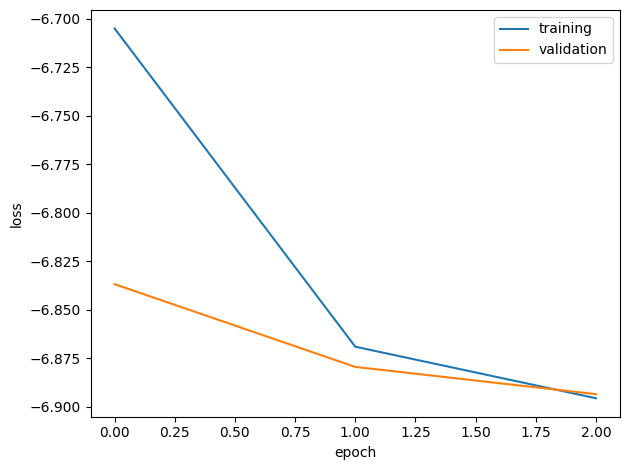

In [12]:
# after 5 epochs, training di

fig, ax = plt.subplots()
ax.plot(np.arange(len(model_snrv.training_losses)), model_snrv.training_losses)
ax.plot(np.arange(len(model_snrv.validation_losses)), model_snrv.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

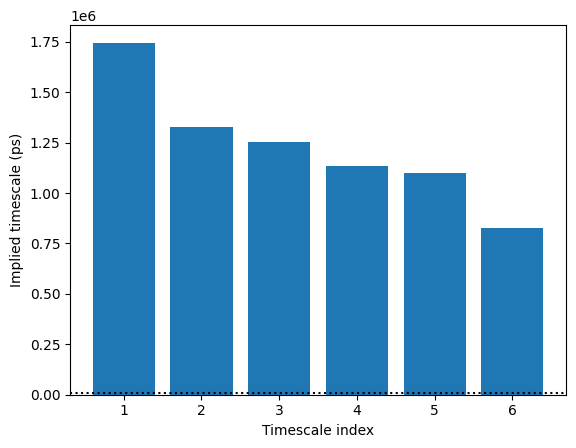

In [13]:
evals = model_snrv.evals.cpu().detach().numpy()
plt.bar(range(1, evals.size), -lag_n*save_freq/np.log(evals[1:]))  # by default use evals[1:]
plt.ylabel('Implied timescale (ps)')
plt.xticks(range(1, evals.size))
plt.xlabel('Timescale index')
plt.axhline(lag_n*save_freq, color='k', linestyle=':')

In [14]:
evecs = model_snrv.transform(torch.cat(coords_torch)).cpu().detach().numpy()
print(evecs.shape)

(20000, 7)


In [15]:
# lag=1 here corresponds to lag=50 in original dataset

import deeptime as dt
tica = dt.decomposition.TICA(lagtime=1, dim=2)
TICs = tica.fit_transform([a.numpy() for a in coords_torch]).reshape(-1, 2)

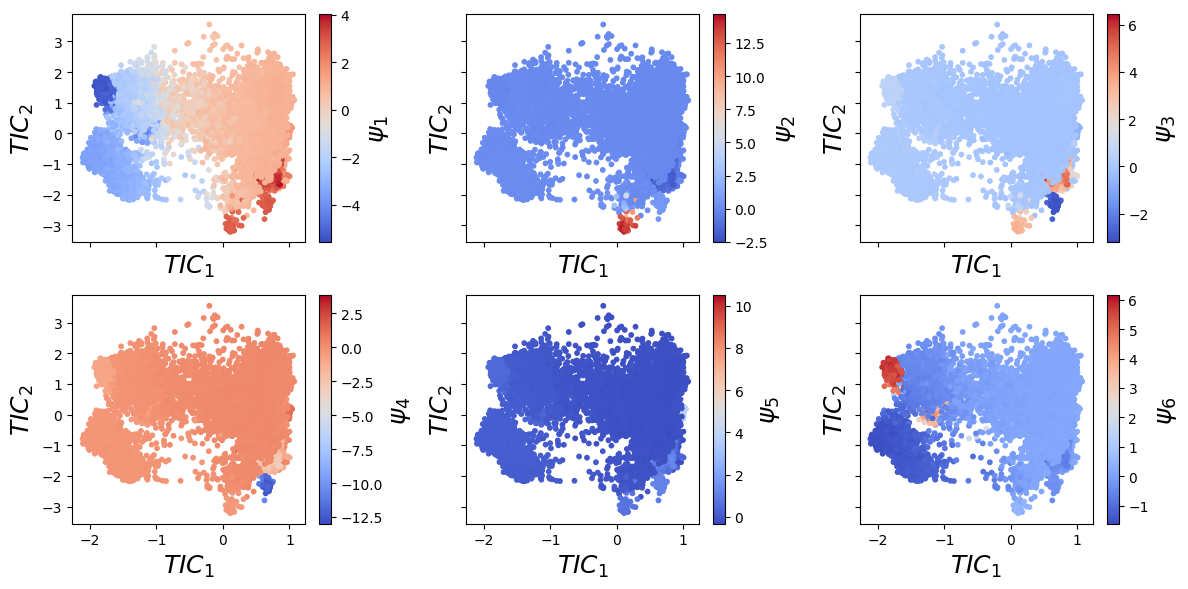

In [16]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6), sharey=True, sharex=True)
axes = axes.flatten()
stride = 1

for e in range(1, evecs.shape[1]):
    evec = evecs[::stride, e]
    ax = axes[e-1]
    
    im = ax.scatter(TICs[::stride, 0], TICs[::stride, 1], c=evec, s=10, cmap='coolwarm')
    ax.set_xlabel('$TIC_1$', fontsize=18)
    ax.set_ylabel('$TIC_2$', fontsize=18)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'$\psi_{e}$', size=18)

plt.tight_layout()

Text(145.72222222222223, 0.5, 'Residue index')

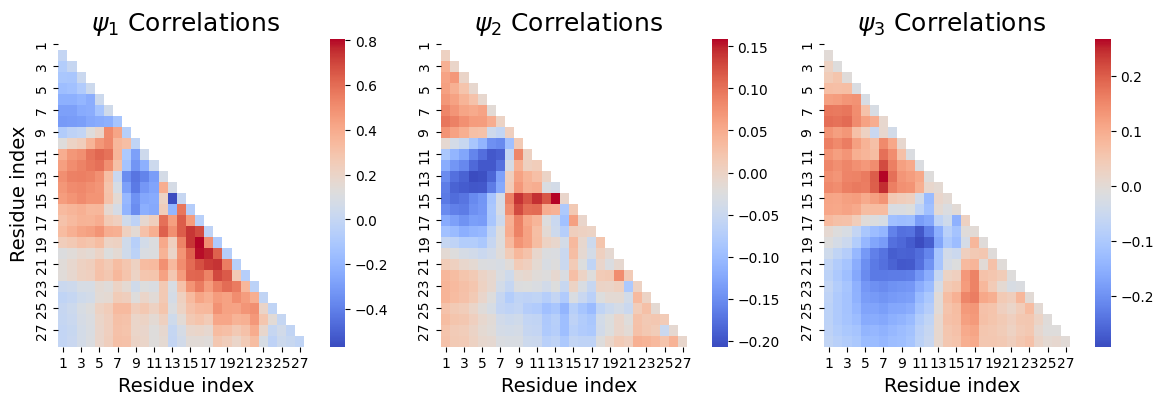

In [84]:
# Interpret modesl by checking correlations against input features (pairwise distances)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

all_feats = np.concatenate(coords_torch)
num_features = all_feats.shape[1]
nres = trjs[0].n_residues

for evec_idx, ax in enumerate(axes):

    heatmap = np.zeros((nres, nres))
    correlations = np.zeros(num_features)
    cnt = 0
    
    for i in range(num_features):
        correlations[i], _ = pearsonr(all_feats[:, i], evecs[:, evec_idx + 1])

    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap[i, j] = correlations[cnt]
            heatmap[j, i] = correlations[cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    sns.heatmap(heatmap, mask=mask, cmap='coolwarm', ax=ax)

    ax.set_title(f'$\psi_{evec_idx+1}$ Correlations', fontsize=18)
    ax.set_xlabel('Residue index', fontsize=14)
    
    ax.set_xticklabels(1 + 2*np.arange(14))
    ax.set_yticklabels(1 + 2*np.arange(14))
    
axes[0].set_ylabel('Residue index', fontsize=14)
    

In [60]:
# convert to MDN format

CVs = [model_snrv.transform(x).cpu().detach()[:, 1:] for x in coords_torch]
CVs_cat = evecs[:, 1:]
CVs[0].shape, len(CVs), CVs_cat.shape, evecs.shape

(torch.Size([2000, 6]), 10, (20000, 6), (20000, 7))

# MDN propagator

In [61]:
model_mdn = Propagator(dim = CVs[0].size(1))

In [62]:
lag_mdn = 50   # set to same as SRV but this does not need to be the case

load_pretrained_mdn = True
save_new_model = False
model_save_path = f'{load_path}model_mdn-100.pth'

if load_pretrained_mdn:
    model_mdn.load_state_dict(torch.load(model_save_path))
    model_mdn.is_fit = True

else:
    model_mdn.fit(CVs, lag = lag_mdn, max_epochs=100)
    if save_new_model:
        torch.save(model_mdn.state_dict(), model_save_path)


In [67]:
# generate 10x longer synthetic traj

n_steps = len(CVs_cat) #10 * len(evecs) / lag_n
x = CVs[0][0][None]
synthetic_traj_CVs = model_mdn.gen_synthetic_traj(x, n_steps)
synthetic_traj_CVs.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([20000, 6])

Text(0.5, 0, 'Simulation Time (ms)')

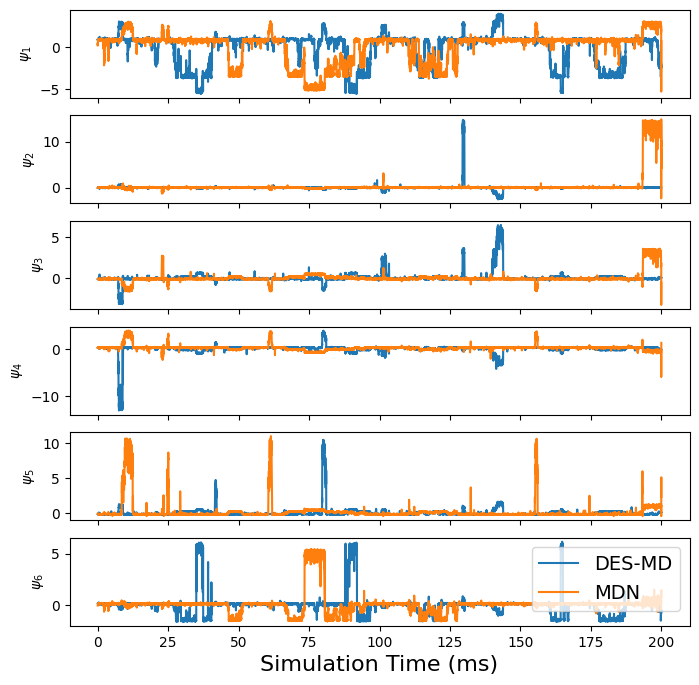

In [68]:
fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

x = 0.01*np.arange(len(evecs))  # convert to ms

for evec_idx, ax in enumerate(axes):
    #ax.plot(x, evecs[:, evec_idx+1], label='DES-MD')
    ax.plot(x, CVs_cat[:, evec_idx], label='DES-MD')
    
    ax.plot(x, synthetic_traj_CVs[:, evec_idx], label='MDN')
    ax.set_ylabel(f'$\psi_{evec_idx+1}$')
    
axes[-1].legend(fontsize=14)
axes[-1].set_xlabel('Simulation Time (ms)', fontsize=16)

/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_ol

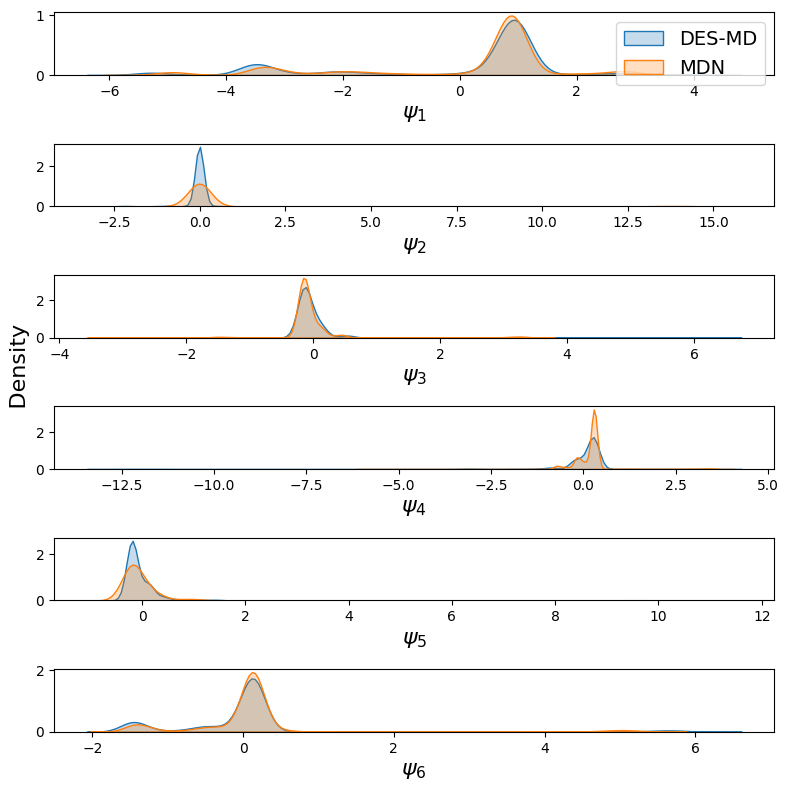

In [71]:
# histograms of all evecs across time -- ensures thermodynamics are approximately reproduced

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=False)

evecs = np.array(evecs)
synthetic_traj_CVs = np.array(synthetic_traj_CVs)
evecs[np.isinf(evecs)] = np.nan
synthetic_traj_CVs[np.isinf(synthetic_traj_CVs)] = np.nan

for evec_idx, ax in enumerate(axes):
    #sns.kdeplot(evecs[:, evec_idx+1], ax=ax, label='DES', fill=True)
    sns.kdeplot(CVs_cat[:, evec_idx], ax=ax, label='DES-MD', fill=True)
    
    sns.kdeplot(synthetic_traj_CVs[:, evec_idx], ax=ax, label='MDN', fill=True)
    ax.set_ylabel('')
    ax.set_xlabel(f'$\psi_{evec_idx+1}$', fontsize=16)

axes[0].legend(fontsize=14)
axes[3].set_ylabel(' '*20 + 'Density', fontsize=16)

plt.tight_layout()
plt.show()



# DDPM Decoder

In [72]:
test_perc = 0.1
n_test = int(trjs[0].xyz.shape[0]*test_perc)
n_train = (trjs[0].xyz.shape[0] - n_test)

xyz_train = [torch.tensor(trj.xyz[n_test:].reshape(n_train, -1)).float() for trj in trjs]
CVs_train = [cv[n_test:] for cv in CVs]

xyz_test = [torch.tensor(trj.xyz[:n_test].reshape(n_test, -1)).float() for trj in trjs]
CVs_test = [cv[:n_test] for cv in CVs]

print(len(xyz_train), xyz_train[0].shape)
print(len(CVs_train), CVs_train[0].shape)

print(len(xyz_test), xyz_test[0].shape)
print(len(CVs_test), CVs_test[0].shape)

10 torch.Size([1800, 84])
10 torch.Size([1800, 6])
10 torch.Size([200, 84])
10 torch.Size([200, 6])


In [75]:
# uses 1000 steps by default, but 50-100 will be much faster and should work fine

n_timesteps = 100
n_epochs = 40

model_ddpm = DDPM(xyz_train[0].shape[1], CVs_train[0].shape[1], timesteps=n_timesteps)

In [76]:
%time

load_pretrained_ddpm = True
save_new_model = False
model_save_path = f'{load_path}model_ddpm-{n_epochs}-eps-{n_timesteps}-ts.pth'

if load_pretrained_ddpm:
    model_ddpm.load_state_dict(torch.load(model_save_path))
    model_ddpm.is_fit = True
    
else:
    model_ddpm.is_fit = False
    model_ddpm.fit(xyz_train, CVs_train, max_epochs=n_epochs)
    if save_new_model:
        torch.save(model_ddpm.state_dict(), model_save_path)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [77]:
# Decode a set of real SRV coordinates first and check adherence to conditioning
# Decoding 10% of the total test set evenly strided (10_000 total)

trj_ref = md.join([trj[:n_test] for trj in trjs])
CVs_ref = torch.Tensor(np.concatenate([cv.numpy() for cv in CVs_test]))  #np.array([cv[0] for cv in CVs_test])

xyz_gen = model_ddpm.generate(torch.Tensor(CVs_ref))
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()

fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)
fake_trj = md.join([ft.superpose(rf) for ft, rf in zip(fake_trj, trj_ref)])

print(trj_ref.xyz.shape, fake_trj.xyz.shape)


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

(2000, 28, 3) (2000, 28, 3)


In [78]:
import random

rmsds_aligned = []
for f_gen, f_ref in zip(fake_trj, trj_ref):
    rmsds_aligned.append(md.rmsd(f_gen, f_ref)[0])
    
rmsds_random = []
rand_list = list(range(len(trj_ref)))
random.shuffle(rand_list)
for f_gen, f_ref in zip(fake_trj, [trj_ref[i] for i in rand_list]):
    rmsds_random.append(md.rmsd(f_gen, f_ref)[0])
    
print(len(rmsds_aligned), len(rmsds_random))

2000 2000


0.72823745
0.8513487


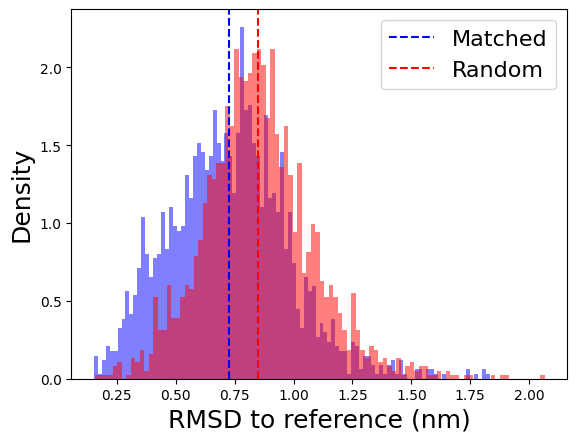

In [79]:
x = np.arange(len(rmsds_aligned))
plt.hist(rmsds_aligned, bins=100, alpha=0.5, color='blue', density=True)
plt.hist(rmsds_random, bins=100, alpha=0.5, color='red', density=True)

plt.axvline(np.mean(rmsds_aligned), linestyle='dashed', c='blue', label='Matched')
plt.axvline(np.mean(rmsds_random), linestyle='dashed', c='red', label='Random')

plt.legend(fontsize=16)
plt.xlabel('RMSD to reference (nm)', fontsize=18)
plt.ylabel('Density', fontsize=18)

print(np.mean(rmsds_aligned))
print(np.mean(rmsds_random))

# values 0.658, 0.856 for 100 diffusion steps

0.335
(54000,)


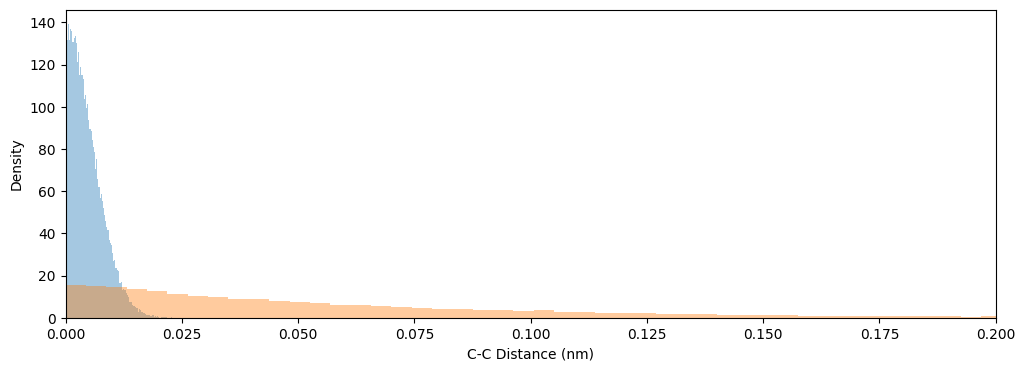

In [80]:
# get the rmsd

import pandas as pd

fig, axes = plt.subplots(figsize=(12, 4))

bonds = np.array([[i, i+1] for i in range(trj_ref.top.n_residues - 1)])
ref_dists = md.compute_distances(trj_ref, bonds)
gen_dists = md.compute_distances(fake_trj, bonds)

ref_dists = np.concatenate(ref_dists)
gen_dists = np.concatenate(gen_dists)

plt.hist(np.abs(ref_dists - np.mean(ref_dists)), bins=100, density=True, alpha=0.4)
plt.hist(np.abs(gen_dists - np.mean(ref_dists)), bins=100, density=True, alpha=0.4)

plt.axvline(np.mean(ref_dists), linestyle='dashed', c='blue', label='Matched')
plt.axvline(np.mean(gen_dists), linestyle='dashed', c='red', label='Random')

ref_min = np.min(ref_dists)
ref_max = np.max(ref_dists)

# Check if each element in gen_dists is between ref_min and ref_max
in_range = (ref_min < gen_dists) & (gen_dists < ref_max)

# Sum the number of elements in gen_dists that are in the specified range
num_in_range = np.sum(in_range)

# Calculate the proportion of elements in the specified range
proportion_in_range = num_in_range / np.prod(gen_dists.shape)
print(proportion_in_range)

plt.xlim(0, 0.2)
plt.xlabel('C-C Distance (nm)')
plt.ylabel('Density')

print(ref_dists.shape)



In [81]:
v = nv.show_mdtraj(trj_ref)
v.add_trajectory(fake_trj)

v[0].clear_representations()
v[0].add_representation('ball+stick', color='blue')

v[1].clear_representations()
v[1].add_representation('ball+stick', color='red')
v

NGLWidget(max_frame=1999)

/home/mikejones/ipykernel_3196775/1119709723.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar


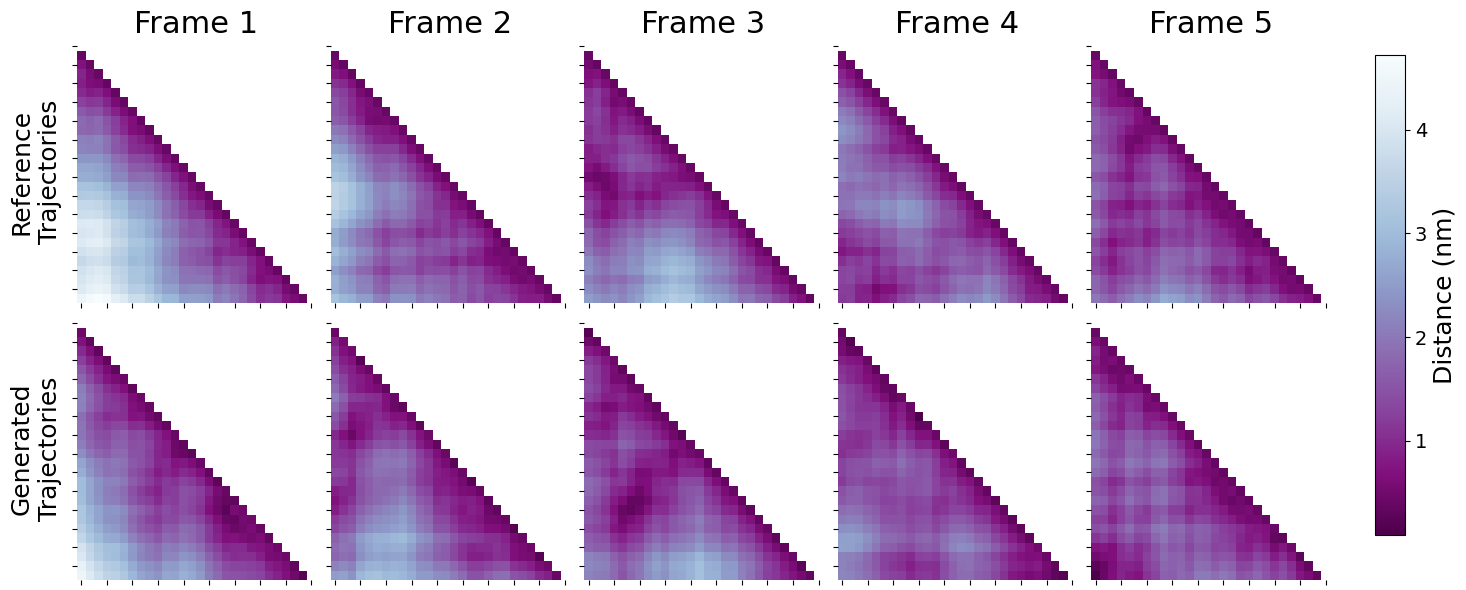

In [85]:
# calculate pairwise distances between each ref and gen structure
# we should observe similar profiles between the top row and bottom row plots

pdists_ref = [torch.pdist(p)[None] for p in torch.tensor(trj_ref.xyz[100::400])]
pdists_gen = [torch.pdist(p)[None] for p in torch.tensor(fake_trj.xyz[100::400])]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

cmap = 'BuPu_r'

global_min = np.inf
global_max = -np.inf

for p_ref, p_gen in zip(pdists_ref, pdists_gen):
    global_min = min(global_min, p_ref.min(), p_gen.min())
    global_max = max(global_max, p_ref.max(), p_gen.max())

# Create heatmaps
for f, (p_ref, p_gen, ax_row) in enumerate(zip(pdists_ref, pdists_gen, axes.T)):
    heatmap_ref = np.zeros((nres, nres))
    heatmap_gen = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap_ref)):
        for j in range(i + 1, nres):
            heatmap_ref[j, i] = p_ref[0, cnt]
            heatmap_gen[j, i] = p_gen[0, cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap_ref, dtype=bool))
    sns.heatmap(heatmap_ref, mask=mask, cmap=cmap, ax=ax_row[0], cbar=False, vmin=global_min, vmax=global_max)
    sns.heatmap(heatmap_gen, mask=mask, cmap=cmap, ax=ax_row[1], cbar=False, vmin=global_min, vmax=global_max)
    ax_row[0].set_title(f'Frame {f+1}', fontsize=22)

# Add the shared colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Position for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=global_min, vmax=global_max))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, label='Distance (nm)')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# Increase tick size and font size
cbar.ax.tick_params(labelsize=14)  # Set the tick label size
cbar.ax.yaxis.label.set_size(18)   # Set the colorbar label font size

axes[0, 0].set_ylabel('Reference\nTrajectories', fontsize=18)
axes[1, 0].set_ylabel('Generated\nTrajectories', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()


# Decode the synthetic traj

In [86]:
xyz_gen = model_ddpm.generate(torch.Tensor(synthetic_traj_CVs[:20]))

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)

In [88]:
# decode first frame of each traj (each has different embeddings)

xyz_ref = [trj.xyz for trj in trjs]
evec_ref = evecs[:10]

# Visualize results

In [89]:
v = nv.show_mdtraj(fake_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=19)